# 3.1 추론 기반 기법과 신경망

In [1]:
import numpy as np

c = np.array([[1,0,0,0,0,0,0]])
W = np.random.randn(7, 3)
h = np.matmul(c, W)
print(h)

[[ 0.69290453 -0.70669504  1.84367627]]


In [2]:
import sys
sys.path.append('..')
from common.layers import MatMul

layer = MatMul(W)
h = layer.forward(c)
print(h)

[[ 0.69290453 -0.70669504  1.84367627]]


# 3.2 단순한 word2vec

In [3]:
c0 = np.array([[1,0,0,0,0,0,0]])
c1 = np.array([[0,0,1,0,0,0,0]])

W_in = np.random.randn(7,3)
W_out = np.random.randn(3, 7)


in_layer0 = MatMul(W_in)
in_layer1 = MatMul(W_in)
out_layer = MatMul(W_out)

h0 = in_layer0.forward(c0)
h1 = in_layer1.forward(c1)
h = 0.5*(h0+h1)
s = out_layer.forward(h)

print(s)

[[-0.01184799  0.48969669 -0.29610799 -0.03244927 -0.03115966  0.36763153
   0.0740441 ]]


# 학습 데이터 준비

In [4]:
from common.util import preprocess

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
print(corpus)

print(id_to_word)

[0 1 2 3 4 1 5 6]
{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}


In [5]:
def create_contexts_target(corpus, window_size = 1):
    target = corpus[window_size:-window_size]
    contexts = []
    
    for idx in range(window_size, len(corpus)-window_size):
        cs = []
        for t in range(-window_size, window_size +1):
            if t == 0:
                continue
            cs.append(corpus[idx + t])
        contexts.append(cs)
        
    return np.array(contexts), np.array(target)

In [6]:
contexts, target = create_contexts_target(corpus, window_size = 1)
print(contexts)
print(target)

[[0 2]
 [1 3]
 [2 4]
 [3 1]
 [4 5]
 [1 6]]
[1 2 3 4 1 5]


In [7]:
from common.util import convert_one_hot

vocab_size = len(word_to_id)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

# 3.4 CBOW 모델 구현

In [8]:
from common.layers import SoftmaxWithLoss

class SimpleCBOW:
    def __init__(self, vocab_size, hidden_size):
        V, H = vocab_size, hidden_size
        
        W_in = 0.01 * np.random.randn(V,H).astype('f')
        W_out = 0.01 * np.random.randn(H,V).astype('f')
        
        self.in_layer0 = MatMul(W_in)
        self.in_layer1 = MatMul(W_in)
        self.out_layer = MatMul(W_out)
        self.loss_layer = SoftmaxWithLoss()
        
        layers = [self.in_layer0, self.in_layer1, self.out_layer]
        self.params, self.grads = [], []
        
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

        self.word_vecs = W_in
        
    def forward(self, contexts, target):
        h0 = self.in_layer0.forward(contexts[:, 0])
        h1 = self.in_layer1.forward(contexts[:, 1])
        h = (h0+h1) *0.5
        score = self.out_layer.forward(h)
        loss = self.loss_layer.forward(score, target)
        return loss
    
    def backward(self, dout =1):
        ds = self.loss_layer.backward(dout)
        da = self.out_layer.backward(ds)
        da *=0.5
        self.in_layer1.backward(da)
        self.in_layer0.backward(da)
        return None

| epoch 1 |  iter 1 / 1 | time 0[s] | loss 1.79
| epoch 2 |  iter 1 / 1 | time 0[s] | loss 1.79
| epoch 3 |  iter 1 / 1 | time 0[s] | loss 1.79
| epoch 4 |  iter 1 / 1 | time 0[s] | loss 1.79
| epoch 5 |  iter 1 / 1 | time 0[s] | loss 1.79
| epoch 6 |  iter 1 / 1 | time 0[s] | loss 1.79
| epoch 7 |  iter 1 / 1 | time 0[s] | loss 1.79
| epoch 8 |  iter 1 / 1 | time 0[s] | loss 1.79
| epoch 9 |  iter 1 / 1 | time 0[s] | loss 1.79
| epoch 10 |  iter 1 / 1 | time 0[s] | loss 1.79
| epoch 11 |  iter 1 / 1 | time 0[s] | loss 1.79
| epoch 12 |  iter 1 / 1 | time 0[s] | loss 1.79
| epoch 13 |  iter 1 / 1 | time 0[s] | loss 1.79
| epoch 14 |  iter 1 / 1 | time 0[s] | loss 1.79
| epoch 15 |  iter 1 / 1 | time 0[s] | loss 1.79
| epoch 16 |  iter 1 / 1 | time 0[s] | loss 1.79
| epoch 17 |  iter 1 / 1 | time 0[s] | loss 1.79
| epoch 18 |  iter 1 / 1 | time 0[s] | loss 1.79
| epoch 19 |  iter 1 / 1 | time 0[s] | loss 1.79
| epoch 20 |  iter 1 / 1 | time 0[s] | loss 1.79
| epoch 21 |  iter 1 / 1 | ti

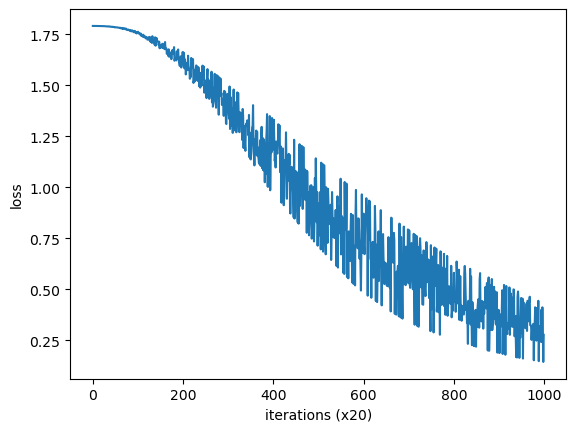

In [9]:
from common.trainer import Trainer
from common.optimizer import Adam

window_size = 1
hidden_size = 5
batch_size = 3
max_epoch = 1000

text = 'You say goodbye I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

vocab_size = len(word_to_id)
target = convert_one_hot(target, vocab_size)
contexts, target = create_contexts_target(corpus, window_size)
contexts = convert_one_hot(contexts, vocab_size)

model = SimpleCBOW(vocab_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

In [10]:
word_vecs = model.word_vecs
for word_id, word in id_to_word.items():
    print(word, word_vecs[word_id])

you [-0.79740083 -0.78185844  0.91555285 -0.8362571  -0.7860951 ]
say [ 0.6283004   0.9713614  -0.8078173   1.1732247  -0.31419563]
goodbye [-1.0645145  -1.1236774  -0.47835964 -0.07560876 -0.94734204]
i [-0.27961516  0.35429296 -0.37982935 -0.60376185 -1.0843168 ]
hello [-0.88240206 -0.8665816   0.9468152  -0.86174273 -0.87130004]
. [0.879617   0.90801346 1.0968789  0.96838117 1.0154353 ]


# 3.5 word2vec 보충